In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot

import statsmodels.formula.api as smf


## Data

Data Source: General Social Survey

[Link to my project on GSS DataExplorer](https://gssdataexplorer.norc.org/projects/28298)
    
[Direct link to download data](https://gssdataexplorer.norc.org/extracts/20141/download)

The download is a gzipped tar file, which you can extract with

```
   tar -xzf gss_2000_2016.tar.gz
```

In [2]:
dct = thinkstats2.ReadStataDct('GSS.dct')
df = dct.ReadFixedWidth('GSS.dat')
print(df.shape)
df.head()

(24350, 38)


,year,compuse,webmob,emailmin,emailhr,usewww,wwwhr,wwwmin,intrhome,parelkid,...,srcbelt,relig,denom,fund,relig16,denom16,fund16,sprel,bible,relactiv1
0,2000,1,0,0,2,1,5,0,0,0,...,3,1,14,1,1,14,1,0,2,0
1,2000,1,0,0,0,2,-1,-1,0,0,...,3,1,18,1,2,0,2,0,0,0
2,2000,2,0,-1,-1,0,-1,-1,0,0,...,3,1,70,2,4,0,3,0,9,0
3,2000,1,0,0,3,1,2,0,0,0,...,3,10,0,9,1,14,1,0,2,0
4,2000,1,0,0,15,1,1,0,0,0,...,3,4,0,3,4,0,3,0,3,0


In [3]:
for colname in df.columns:
    print(colname, end='  ')

year  compuse  webmob  emailmin  emailhr  usewww  wwwhr  wwwmin  intrhome  parelkid  hispanic  sei  cohort  ballot  wtssall  sei10  tvhours  relactiv  god  conclerg  id_  age  educ  sex  race  res16  income  rincome  srcbelt  relig  denom  fund  relig16  denom16  fund16  sprel  bible  relactiv1  

## Cleaning and validation

In [4]:
def countnan(series):
    return np.sum(np.isnan(series))

In [5]:
def values(df, varname):
    """Values and counts in index order.
    
    df: DataFrame
    varname: strign column name
    
    returns: Series that maps from value to frequency
    """
    return df[varname].value_counts().sort_index()

In [6]:
values(df, 'year')

2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
Name: year, dtype: int64

In [7]:
countnan(df.wtssall)

0

In [8]:
resampled = thinkstats2.ResampleRowsWeighted(df, 'wtssall')

In [9]:
resampled.shape

(24350, 38)

In [10]:
cycle = df[df.year==2008]
values(cycle, 'wwwhr')

-1    2023
Name: wwwhr, dtype: int64

In [11]:
values(df, 'wwwhr')

-1      12726
 0       1202
 1       1517
 2       1304
 3        819
 4        593
 5        913
 6        358
 7        449
 8        294
 9         37
 10       946
 11        13
 12       201
 13        18
 14       231
 15       420
 16        35
 17        11
 18        22
 19         1
 20       559
 21        78
 22         7
 23         7
 24        43
 25       173
 26         2
 27         5
 28        45
        ...  
 49         2
 50        79
 55         4
 56         3
 60        48
 63         2
 64         1
 65         6
 66         1
 70        24
 72         6
 75         6
 80        20
 84         5
 85         1
 86         1
 90         4
 91         2
 98         1
 100       11
 112        2
 120        5
 122        1
 130        1
 132        1
 140        1
 168        2
 184        1
 998       54
 999      451
Name: wwwhr, dtype: int64

In [12]:
asked = resampled[resampled.wwwhr != -1].copy()
asked.shape

(12074, 38)

In [13]:
values(asked, 'year')

2000    1153
2002    1712
2004    1884
2006    2152
2010    1046
2012    1051
2014    1453
2016    1623
Name: year, dtype: int64

In [14]:
def fill_missing(df, varname, badvals=[98, 99]):
    """Fill missing data with random values.
    
    df: DataFrame
    varname: string column name
    badvals: list of values to be replaced
    """
    df[varname].replace(badvals, np.nan, inplace=True)
    null = df[varname].isnull()
    fill = np.random.choice(df[varname].dropna(), sum(null), replace=True)
    df.loc[null, varname] = fill
    return sum(null)

In [15]:
fill_missing(asked, 'relig')
values(asked, 'relig')

1.0     5599
2.0     2953
3.0      232
4.0     2324
5.0      148
6.0      124
7.0       72
8.0       30
9.0       68
10.0      45
11.0     413
12.0      11
13.0      55
Name: relig, dtype: int64

In [16]:
asked['has_relig'] = (df.relig != 4).astype(int)
values(asked, 'has_relig')

0    2312
1    9762
Name: has_relig, dtype: int64

In [17]:
fill_missing(asked, 'wwwhr', [998, 999])

528

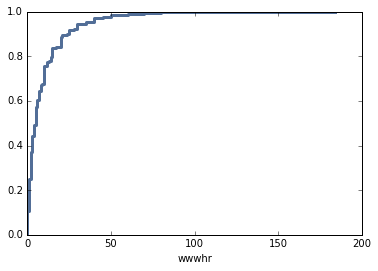

In [18]:
cdf = thinkstats2.Cdf(asked.wwwhr)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='wwwhr')

In [19]:
asked.wwwhr.describe()

count    12074.000000
mean         9.222627
std         13.235644
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        184.000000
Name: wwwhr, dtype: float64

## Basic model

In [20]:
results = smf.logit('has_relig ~ wwwhr', data=asked).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.485204
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              has_relig   No. Observations:                12074
Model:                          Logit   Df Residuals:                    12072
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Apr 2017   Pseudo R-squ.:                0.006484
Time:                        14:23:35   Log-Likelihood:                -5858.3
converged:                       True   LL-Null:                       -5896.6
                                        LLR p-value:                 2.236e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5784      0.028     55.565      0.000       1.523       1.634
wwwhr         -0.0139      0.002     -8.984      0.000      -0.017      -0.011
==============================================================================
"""

## Additional variables

In [21]:
asked['www50'] = asked.wwwhr >= 5
asked['www75'] = asked.wwwhr >= 10

In [22]:
asked.groupby('year')[['wwwhr', 'www50', 'www75']].mean()

,wwwhr,www50,www75
year,,,
2000,5.603643,0.379011,0.203816
2002,5.892523,0.386682,0.212033
2004,7.721338,0.468153,0.273885
2006,9.205390,0.499535,0.323885
2010,9.679732,0.558317,0.362333
2012,10.881066,0.571836,0.372978
2014,11.924983,0.587061,0.415003
2016,13.284042,0.635860,0.455330


In [23]:
fill_missing(asked, 'relig16')
values(asked, 'relig16')

1.0     6091
2.0     4111
3.0      260
4.0      960
5.0       64
6.0       81
7.0       73
8.0       12
9.0      101
10.0      49
11.0     258
12.0       5
13.0       9
Name: relig16, dtype: int64

In [24]:
asked['raised'] = asked.relig16 != 4
values(asked, 'raised')

False      960
True     11114
Name: raised, dtype: int64

In [25]:
values(asked, 'sex')

1    5668
2    6406
Name: sex, dtype: int64

In [26]:
values(asked, 'race')

1    9378
2    1403
3    1293
Name: race, dtype: int64

In [27]:
fill_missing(asked, 'hispanic')
values(asked, 'hispanic')

1.0     10640
2.0       833
3.0       139
4.0        68
5.0        53
6.0        26
7.0         6
8.0        15
9.0         3
10.0        9
11.0       25
15.0       32
20.0       24
21.0       17
22.0       25
23.0        5
24.0        9
25.0        4
30.0       75
31.0        1
35.0        4
40.0        1
41.0       16
45.0        2
46.0        6
47.0       23
50.0       13
Name: hispanic, dtype: int64

In [28]:
fill_missing(asked, 'educ')
values(asked, 'educ')

0.0       14
1.0        9
2.0       42
3.0       10
4.0       14
5.0       18
6.0       72
7.0       14
8.0       95
9.0      130
10.0     229
11.0     394
12.0    2762
13.0    1251
14.0    1825
15.0     791
16.0    2388
17.0     566
18.0     737
19.0     276
20.0     437
Name: educ, dtype: int64

In [29]:
fill_missing(asked, 'income')
values(asked, 'income')

1.0      111
2.0      122
3.0       76
4.0       52
5.0       62
6.0       61
7.0       50
8.0      110
9.0      421
10.0     460
11.0     611
12.0    9060
13.0     878
Name: income, dtype: int64

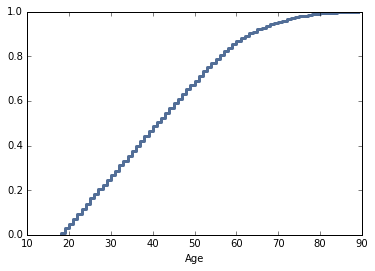

In [30]:
fill_missing(asked, 'age')
cdf = thinkstats2.Cdf(asked.age)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Age')

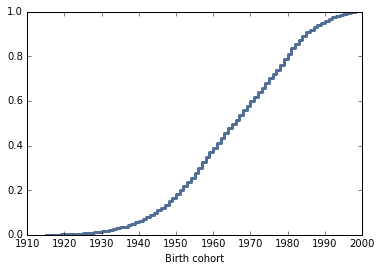

In [31]:
fill_missing(asked, 'cohort', [9999])
cdf = thinkstats2.Cdf(asked.cohort)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Birth cohort')

In [32]:
values(asked, 'year')

2000    1153
2002    1712
2004    1884
2006    2152
2010    1046
2012    1051
2014    1453
2016    1623
Name: year, dtype: int64

In [33]:
values(asked, 'srcbelt')

1     980
2    1513
3    1775
4    2186
5    4568
6    1052
Name: srcbelt, dtype: int64

In [34]:
asked['urban'] = asked.srcbelt <= 2
asked['rural'] = asked.srcbelt >= 5

In [35]:
fill_missing(asked, 'res16', [8, 9, 0])
values(asked, 'res16')

1.0    1249
2.0     841
3.0    3886
4.0    2170
5.0    2027
6.0    1901
Name: res16, dtype: int64

In [36]:
asked['farm'] = asked.res16 == 1
asked['country'] = asked.res16 == 2
asked['city'] = asked.res16 == 6

In [37]:
fill_missing(asked, 'sei10', [0.0])

406

In [38]:
values(asked, 'sei10')

9.0       1
10.6     22
12.4     10
12.6     89
13.2     20
13.3     29
13.6    140
14.0     83
14.4      9
14.6     14
14.8     17
15.8      7
17.0     12
17.1     22
17.5     22
18.6     84
18.8     10
19.2      5
19.6    202
19.7     19
20.0      8
20.1     66
20.3      2
20.5     18
20.7    130
20.8     43
20.9     32
21.0      8
21.1      2
21.3      3
       ... 
85.0      6
85.2     41
85.5     10
85.8      9
86.0      2
86.1      8
86.5     40
86.6     15
86.7     21
86.8     11
86.9      1
87.3     16
87.6     13
87.9     90
88.0      7
88.3      9
88.6      4
88.7     34
89.1     11
89.3     12
89.4      2
89.9      1
91.1     78
91.6      2
91.9      3
92.0      9
92.1     12
92.2      4
92.8     65
99.9    106
Name: sei10, dtype: int64

In [39]:
for name, group in asked.groupby('year'):
    print(name, countnan(group.sei10))

2000 0
2002 0
2004 0
2006 0
2010 0
2012 0
2014 0
2016 0


In [40]:
fill_missing(asked, 'relactiv')

29

In [41]:
values(asked, 'relactiv')

0.0     4758
1.0     3173
2.0      617
3.0      988
4.0      776
5.0      480
6.0      486
7.0      185
8.0      516
9.0       64
10.0      31
Name: relactiv, dtype: int64

Note: If we're going to use `tvhours`, we should limit to people who were asked both `tvhours` and `wwwhr`

In [42]:
fill_missing(asked, 'tvhours')

41

In [43]:
values(asked, 'tvhours')

-1.0     3414
 0.0      623
 1.0     2130
 2.0     2528
 3.0     1417
 4.0      895
 5.0      472
 6.0      264
 7.0       56
 8.0      105
 9.0       16
 10.0      52
 11.0       8
 12.0      46
 13.0       5
 14.0      13
 15.0      11
 16.0       4
 18.0       2
 20.0      10
 24.0       3
Name: tvhours, dtype: int64

## Other dependent vars

In [44]:
fill_missing(asked, 'god', [8, 9])
values(asked, 'god')

0.0    4187
1.0     280
2.0     437
3.0     959
4.0     313
5.0    1376
6.0    4522
Name: god, dtype: int64

In [45]:
fill_missing(asked, 'bible', [8, 9, 0])
values(asked, 'bible')

1.0    3557
2.0    5840
3.0    2489
4.0     188
Name: bible, dtype: int64

In [46]:
fill_missing(asked, 'conclerg', [8, 9, 0])
values(asked, 'conclerg')

1.0    2278
2.0    6957
3.0    2839
Name: conclerg, dtype: int64

## Other classifiers

In [47]:
formula = ('has_relig ~ www50 + sex + educ + raised')
results = smf.logit(formula, data=asked).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.442230
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              has_relig   No. Observations:                12074
Model:                          Logit   Df Residuals:                    12069
Method:                           MLE   Df Model:                            4
Date:                Mon, 17 Apr 2017   Pseudo R-squ.:                 0.09448
Time:                        14:23:39   Log-Likelihood:                -5339.5
converged:                       True   LL-Null:                       -5896.6
                                        LLR p-value:                6.341e-240
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4655      0.164     -2.841      0.004      -0.787      -0.144
www50[T.True]     -0.4468      0.050     -8.927      0.000      -0.545      -0.349
raised[T.True]     2.2078      0.072     30.462      0.000       2.066       2.350
sex                0.3330      0.049      6.745      0.000       0.236       0.430
educ              -0.0209      0.009     -2.354      0.019      -0.038      -0.003
==================================================================================
"""

In [48]:
y = asked.has_relig
y.shape

(12074,)

In [49]:
X = asked[['www50', 'sex', 'educ', 'raised']]
X.shape

(12074, 4)

In [50]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [51]:
logreg.coef_

array([[-0.44680306,  0.33303308, -0.02087852,  2.20780052]])

In [52]:
logreg.intercept_

array([-0.46549478])

In [53]:
yfit = logreg.predict(X)

In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(y, yfit)

0.82839158522444922

In [55]:
np.mean(y)

0.8085141626635747

In [56]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [57]:
logreg.fit(Xtrain, ytrain)
yfit = logreg.predict(Xtest)
accuracy_score(ytest, yfit)

0.8214640609473336

In [58]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X, y)
scores.mean()

0.82772909129076477

http://scikit-learn.org/stable/modules/ensemble.html

In [59]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
scores = cross_val_score(bagging, X, y)
scores.mean()

0.81298622344607308

In [60]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf, X, y)
scores.mean()

0.8289713067351584

In [61]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2)
scores = cross_val_score(clf, X, y)
scores.mean()

0.8289713067351584

In [62]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
scores = cross_val_score(clf, X, y)
scores.mean()

0.82905412247014798

Note: We don't really care about guessing who is affiliated or not.  What other accuracy metrics should we consider?

## Feature Selection Using Random Forest

[Following this example](https://chrisalbon.com/machine-learning/feature_selection_using_random_forest.html)

In [63]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [64]:
y = asked.has_relig
y.shape

(12074,)

In [65]:
cols = list(asked.columns)
cols.remove('relig')
cols.remove('denom')
cols.remove('fund')
cols.remove('sprel')
cols.remove('has_relig')
cols.remove('god')
cols.remove('bible')
cols.remove('conclerg')
cols.remove('id_')
cols.remove('year')
cols.remove('wtssall')
cols.remove('sei')
cols.remove('relactiv')
cols.remove('relactiv1')
cols

[u'compuse',
 u'webmob',
 u'emailmin',
 u'emailhr',
 u'usewww',
 u'wwwhr',
 u'wwwmin',
 u'intrhome',
 u'parelkid',
 u'hispanic',
 u'cohort',
 u'ballot',
 u'sei10',
 u'tvhours',
 u'age',
 u'educ',
 u'sex',
 u'race',
 u'res16',
 u'income',
 u'rincome',
 u'srcbelt',
 u'relig16',
 u'denom16',
 u'fund16',
 'www50',
 'www75',
 'raised',
 'urban',
 'rural',
 'farm',
 'country',
 'city']

In [66]:
X = asked[cols]
X.shape

(12074, 33)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [68]:
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [69]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [70]:
for feature in sorted(zip(clf.feature_importances_, cols)):
    print(feature)

(0.0, u'parelkid')
(0.0029067330380193423, u'webmob')
(0.0051201776778140879, 'country')
(0.0070071169291810748, 'farm')
(0.0091197045270093677, 'www50')
(0.009167919256894896, 'www75')
(0.0091691324343430459, 'city')
(0.0095969893625741758, 'urban')
(0.011058181088292622, u'compuse')
(0.011714267543789644, 'rural')
(0.012085676240071307, u'usewww')
(0.014730656891025967, u'race')
(0.01534696091882181, u'intrhome')
(0.015790668027344693, u'hispanic')
(0.016305553998937045, u'sex')
(0.018412775279022228, u'wwwmin')
(0.023528504800513102, u'ballot')
(0.02632634938944816, u'emailmin')
(0.027010377187131167, u'income')
(0.031300789451890916, u'fund16')
(0.036110673567019642, u'srcbelt')
(0.037573816019885908, u'denom16')
(0.03791881178732763, u'res16')
(0.040682846449169356, u'rincome')
(0.044886227042674115, u'relig16')
(0.046056676889680355, u'tvhours')
(0.048210651598457187, 'raised')
(0.051247783115001597, u'emailhr')
(0.055735213947322268, u'educ')
(0.061196265975715744, u'wwwhr')
(0.

In [76]:
sfm = SelectFromModel(clf, threshold=0.027)

In [77]:
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
        prefit=False, threshold=0.027)

In [78]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [79]:
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [80]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)



0.90434782608695652

In [81]:
y_important_pred = clf_important.predict(X_important_test)
accuracy_score(y_test, y_important_pred)


0.9024844720496894

## Ridge and Lasso regression

In [83]:
from sklearn.linear_model import Lasso


In [84]:
lassoreg = Lasso(alpha=1, normalize=True, max_iter=1e5)


In [85]:
predictors = ['has_relig']
lassoreg.fit(asked[predictors], asked['wwwhr'])

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=100000.0,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [87]:
y_pred = lassoreg.predict(asked[predictors])


ValueError: Can't handle mix of multiclass and continuous

In [88]:
rss = sum((y_pred-asked['wwwhr'])**2)

In [89]:
lassoreg.intercept_

9.2226271326817955

In [90]:
lassoreg.coef_

array([-0.])

In [100]:
for colname in df.columns:
    print(colname, end='  ')

year  compuse  webmob  emailmin  emailhr  usewww  wwwhr  wwwmin  intrhome  parelkid  hispanic  sei  cohort  ballot  wtssall  sei10  tvhours  relactiv  god  conclerg  id_  age  educ  sex  race  res16  income  rincome  srcbelt  relig  denom  fund  relig16  denom16  fund16  sprel  bible  relactiv1  

In [109]:
formula = ('has_relig ~ cohort + year + C(sex) + C(race) + hispanic + sei10 +'
    'raised + educ + wwwhr')
results = smf.logit(formula, data=asked).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.431695
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              has_relig   No. Observations:                12074
Model:                          Logit   Df Residuals:                    12063
Method:                           MLE   Df Model:                           10
Date:                Mon, 17 Apr 2017   Pseudo R-squ.:                  0.1160
Time:                        15:30:21   Log-Likelihood:                -5212.3
converged:                       True   LL-Null:                       -5896.6
                                        LLR p-value:                6.014e-288
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         90.1090      9.585      9.401      0.000      71.323     108.895
C(sex)[T.2]        0.3587      0.050      7.167      0.000       0.261       0.457
C(race)[T.2]       0.3660      0.085      4.328      0.000       0.200       0.532
C(race)[T.3]       0.3187      0.084      3.808      0.000       0.155       0.483
raised[T.True]     2.1240      0.074     28.742      0.000       1.979       2.269
cohort            -0.0258      0.002    -14.269      0.000      -0.029      -0.022
year              -0.0196      0.005     -4.044      0.000      -0.029      -0.010
hispanic          -0.0088      0.005     -1.716      0.086      -0.019       0.001
sei10             -0.0028      0.001     -2.208      0.027      -0.005      -0.000
educ              -0.0324      0.011     -3.087      0.002      -0.053      -0.012
wwwhr             -0.0055      0.002     -3.146      0.002      -0.009      -0.002
==================================================================================
"""

In [108]:
formula = ('wwwhr ~ cohort + year + C(sex) + C(race) + hispanic + sei10 +'
    'raised + educ + has_relig')
results = smf.ols(formula, data=asked).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  wwwhr   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     93.44
Date:                Mon, 17 Apr 2017   Prob (F-statistic):          5.65e-187
Time:                        15:29:54   Log-Likelihood:                -47867.
No. Observations:               12074   AIC:                         9.576e+04
Df Residuals:                   12063   BIC:                         9.584e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1011.1674     44.141    -22.908      0.000   -1097.691    -924.644
C(sex)[T.2]       -1.2193      0.234     -5.215      0.000      -1.678      -0.761
C(race)[T.2]       1.0913      0.370      2.949      0.003       0.366       1.817
C(race)[T.3]       1.9466      0.386      5.039      0.000       1.189       2.704
raised[T.True]    -1.5111      0.455     -3.324      0.001      -2.402      -0.620
cohort             0.1199      0.008     15.015      0.000       0.104       0.136
year               0.3894      0.022     17.507      0.000       0.346       0.433
hispanic           0.0311      0.027      1.164      0.245      -0.021       0.083
sei10              0.0394      0.006      6.552      0.000       0.028       0.051
educ               0.2440      0.048      5.133      0.000       0.151       0.337
has_relig         -1.1527      0.317     -3.638      0.000      -1.774      -0.532
==============================================================================
Omnibus:                     8662.617   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           178352.240
Skew:                           3.246   Prob(JB):                         0.00
Kurtosis:                      20.674   Cond. No.                     1.07e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""